## Init

In [1]:
import os

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find('project')
# slice the path from the index of 'project' to the end
project_path = path[:index_project+7]
# set the working directory
os.chdir(project_path+'/src')
print(f'Project path set to: {os.getcwd()}')

Project path set to: c:\Github\new-peak-project\src


In [33]:
from dotenv import dotenv_values
config = {
    "DATA_PATH": "I:\\My Drive\\DAWSON PHD PROJECT\\Biomarker Data Repository\\data\\new-peak-project\\experiments"
}
print(config["DATA_PATH"])

I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments


## Data Preparation

In [34]:
from scripts.matlab.load_time_course_data import load_timecourse_data
from scripts.matlab.load_target_data import load_target_data
from models.Utils import last_time_point_method, dynamic_features_method
import pandas as pd 
import pickle

# distortion_scales = [0.05, 0.1, 0.2, 0.3, 0.5, 1] # version = "2026-01-v1"
distortion_scales = [0.05, 1, 2, 3, 5, 7, 10] # version = "2026-01-v2"
filename_label = 'adaptive_suboptimal_data'
version = "2026-01-v2"
simulation_datasets = []
for scale in distortion_scales:
    str_scale = str(scale)
    sim_data = pd.read_csv(f'{config["DATA_PATH"]}/matlab_output/{version}/{filename_label}_{str_scale}.csv', index_col=0)
    simulation_datasets.append(sim_data)

feature_data_file_path = f'notebooks/tests/shared_dir/src/feature_data.pkl'
with open(feature_data_file_path, 'rb') as f:
    feature_data = pickle.load(f)
    
    


In [35]:
ground_truth_data_file_path = f'{config["DATA_PATH"]}/matlab_output/ground_truth_data.csv'
ground_truth_sim_data = pd.read_csv(ground_truth_data_file_path, index_col=0)
ground_time_course_data = load_timecourse_data(ground_truth_sim_data, index_option='cell_id')
target_data = load_target_data(ground_truth_sim_data, 'pERK', index_option='cell_id')

# process other simulation datasets to time course data
time_course_data_suboptimal = {}
for i, sim_data in enumerate(simulation_datasets):
    scale = distortion_scales[i]
    time_course_data = load_timecourse_data(sim_data, index_option='cell_id')
    time_course_data_suboptimal[scale] = time_course_data
    
all_species = list(ground_time_course_data.columns)
# remove 'pERK' from all_species since it is the target variable
all_species.remove('pERK')

last_time_data = last_time_point_method(ground_time_course_data, all_species)
dynamic_data = dynamic_features_method(ground_time_course_data, all_species, n_cores=8)

combined_lp_data = pd.concat([feature_data, last_time_data], axis=1)
combined_dyn_data = pd.concat([feature_data, dynamic_data], axis=1)

feature_data_list = [feature_data, last_time_data, dynamic_data, combined_lp_data, combined_dyn_data]
feature_data_names = ['feature_data', 'last_time_data', 'dynamic_data', 'combined_lp_data', 'combined_dyn_data']
o_random_seed = 42
target_name = 'pERK'


# process the simulation datasets into dynamic features
suboptimal_feature_data_lists = []
# first add in the ground truth data feature data list 
suboptimal_feature_data_lists.append(feature_data_list)

for i, sim_data in enumerate(simulation_datasets):
    scale = distortion_scales[i]
    time_course_data = time_course_data_suboptimal[scale]
    
    last_time_data = last_time_point_method(time_course_data, all_species)
    dynamic_data = dynamic_features_method(time_course_data, all_species, n_cores=8)
    
    combined_lp_data = pd.concat([feature_data, last_time_data], axis=1)
    combined_dyn_data = pd.concat([feature_data, dynamic_data], axis=1)
    
    suboptimal_feature_data_lists.append([feature_data, last_time_data, dynamic_data, combined_lp_data, combined_dyn_data])


output_file_path = f'{config["DATA_PATH"]}/matlab_output/{version}/exp23_eval_results.pkl' 

## Machine Learning 

In [26]:
print(f'Loading libraries...')
import pandas as pd
from ml.Workflow import batch_eval_standard

# add 1 into distortion_scales to match the number of feature data lists
distortion_scales_modified = distortion_scales.copy()

all_results = []
for i, scale in enumerate(distortion_scales_modified):
    feature_data_list = suboptimal_feature_data_lists[i]
    print(f"Running evaluation for distortion scale = {scale}...")
    metric_df = batch_eval_standard(
        feature_data_list=feature_data_list,
        feature_data_names=feature_data_names,
        target_data=target_data,
        target_name=target_name,
        num_repeats=10,
        test_size=0.2,
        o_random_seed=o_random_seed,
        n_jobs=8
    )
    metric_df["distortion_scale"] = scale
    all_results.append(metric_df)
    print(f"Completed: distortion scale = {scale}, shape = {metric_df.shape}")


final_df = pd.concat(all_results, ignore_index=True)
with open(output_file_path, 'wb') as f:
    pickle.dump(final_df, f)
print(f"Results saved to {output_file_path}")

Loading libraries...
Running evaluation for distortion scale = 0.05...
Completed: distortion scale = 0.05, shape = (250, 7)
Running evaluation for distortion scale = 0.1...
Completed: distortion scale = 0.1, shape = (250, 7)
Running evaluation for distortion scale = 0.2...
Completed: distortion scale = 0.2, shape = (250, 7)
Running evaluation for distortion scale = 0.3...
Completed: distortion scale = 0.3, shape = (250, 7)
Running evaluation for distortion scale = 0.5...
Completed: distortion scale = 0.5, shape = (250, 7)
Running evaluation for distortion scale = 1...
Completed: distortion scale = 1, shape = (250, 7)
Results saved to I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments/matlab_output/2026-01-v1/exp23_eval_results.pkl


## Visualisation

In [36]:
# load the results
with open(output_file_path, 'rb') as f:
    results_df = pickle.load(f)

In [37]:
results_df

,Model,Feature Data,Mean Squared Error,R2 Score,Pearson Correlation,Pearson P-Value,distortion_scale
0,Linear Regression,feature_data,3.010706e+07,0.645668,0.808963,3.996814e-13,0.05
1,Linear Regression,feature_data,2.978134e+07,0.685539,0.876160,1.813371e-17,0.05
2,Linear Regression,feature_data,2.489395e+07,0.391084,0.709902,3.794150e-09,0.05
3,Linear Regression,feature_data,2.309846e+07,0.476354,0.712514,3.133166e-09,0.05
4,Linear Regression,feature_data,2.857129e+07,0.721367,0.903340,5.147987e-20,0.05
...,...,...,...,...,...,...,...
1745,Neural Network,combined_dyn_data,3.891851e+07,0.596012,0.778584,1.085892e-11,10.00
1746,Neural Network,combined_dyn_data,2.385936e+07,0.468529,0.699200,8.135755e-09,10.00
1747,Neural Network,combined_dyn_data,3.010968e+07,0.290699,0.578761,6.976180e-06,10.00
1748,Neural Network,combined_dyn_data,6.932976e+07,-0.747576,0.384352,4.905529e-03,10.00


In [38]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1750 entries, 0 to 1749
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Model                1750 non-null   object 
 1   Feature Data         1750 non-null   object 
 2   Mean Squared Error   1750 non-null   float64
 3   R2 Score             1750 non-null   float64
 4   Pearson Correlation  1750 non-null   float64
 5   Pearson P-Value      1750 non-null   float64
 6   distortion_scale     1750 non-null   float64
dtypes: float64(5), object(2)
memory usage: 95.8+ KB


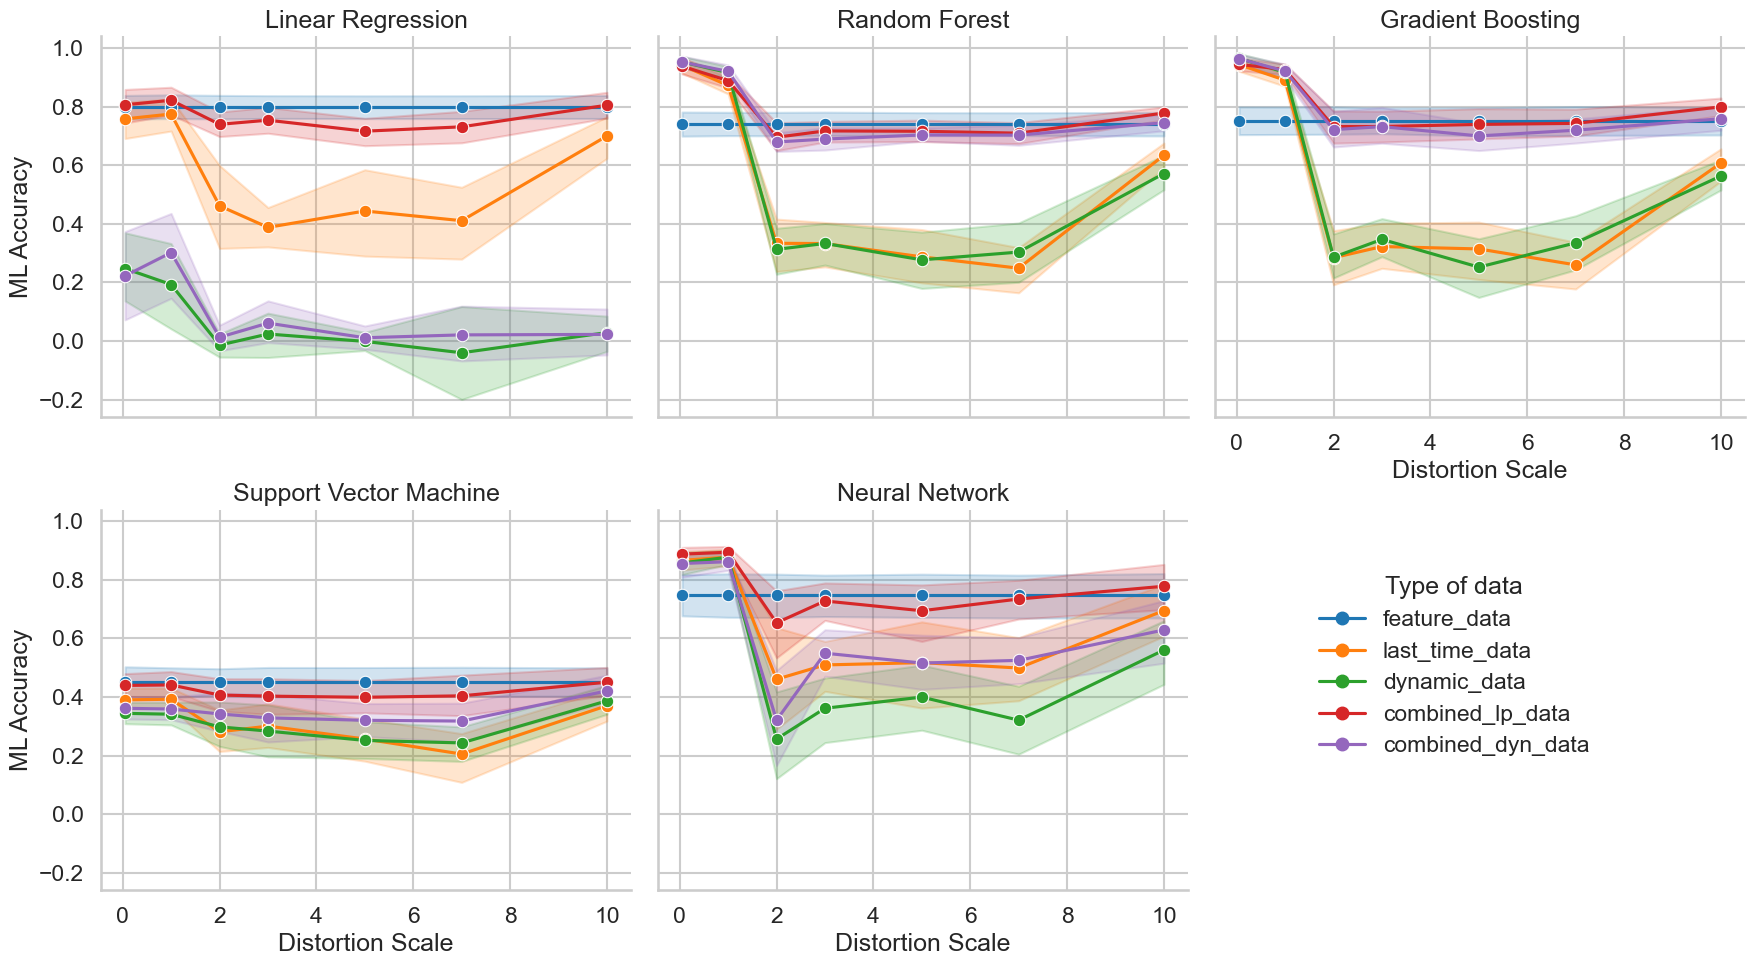

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

# Set up plot appearance
sns.set_context("talk", font_scale=1)
sns.set_style("whitegrid")
matplotlib.rcParams['font.family'] = 'Arial'

# Use relplot to stratify by Model, with at least 2 columns
g = sns.relplot(
    data=results_df,
    x="distortion_scale",
    y="Pearson Correlation",
    hue="Feature Data",
    kind="line",
    col="Model",
    col_wrap=3,
    marker="o",
    facet_kws={"sharey": True},
)

g.set_axis_labels('Distortion Scale', 'ML Accuracy')
g.set_titles('{col_name}')
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(0)
g._legend.set_title('Type of data')
g._legend.set_bbox_to_anchor((0.9, 0.3))
plt.tight_layout()
plt.show()

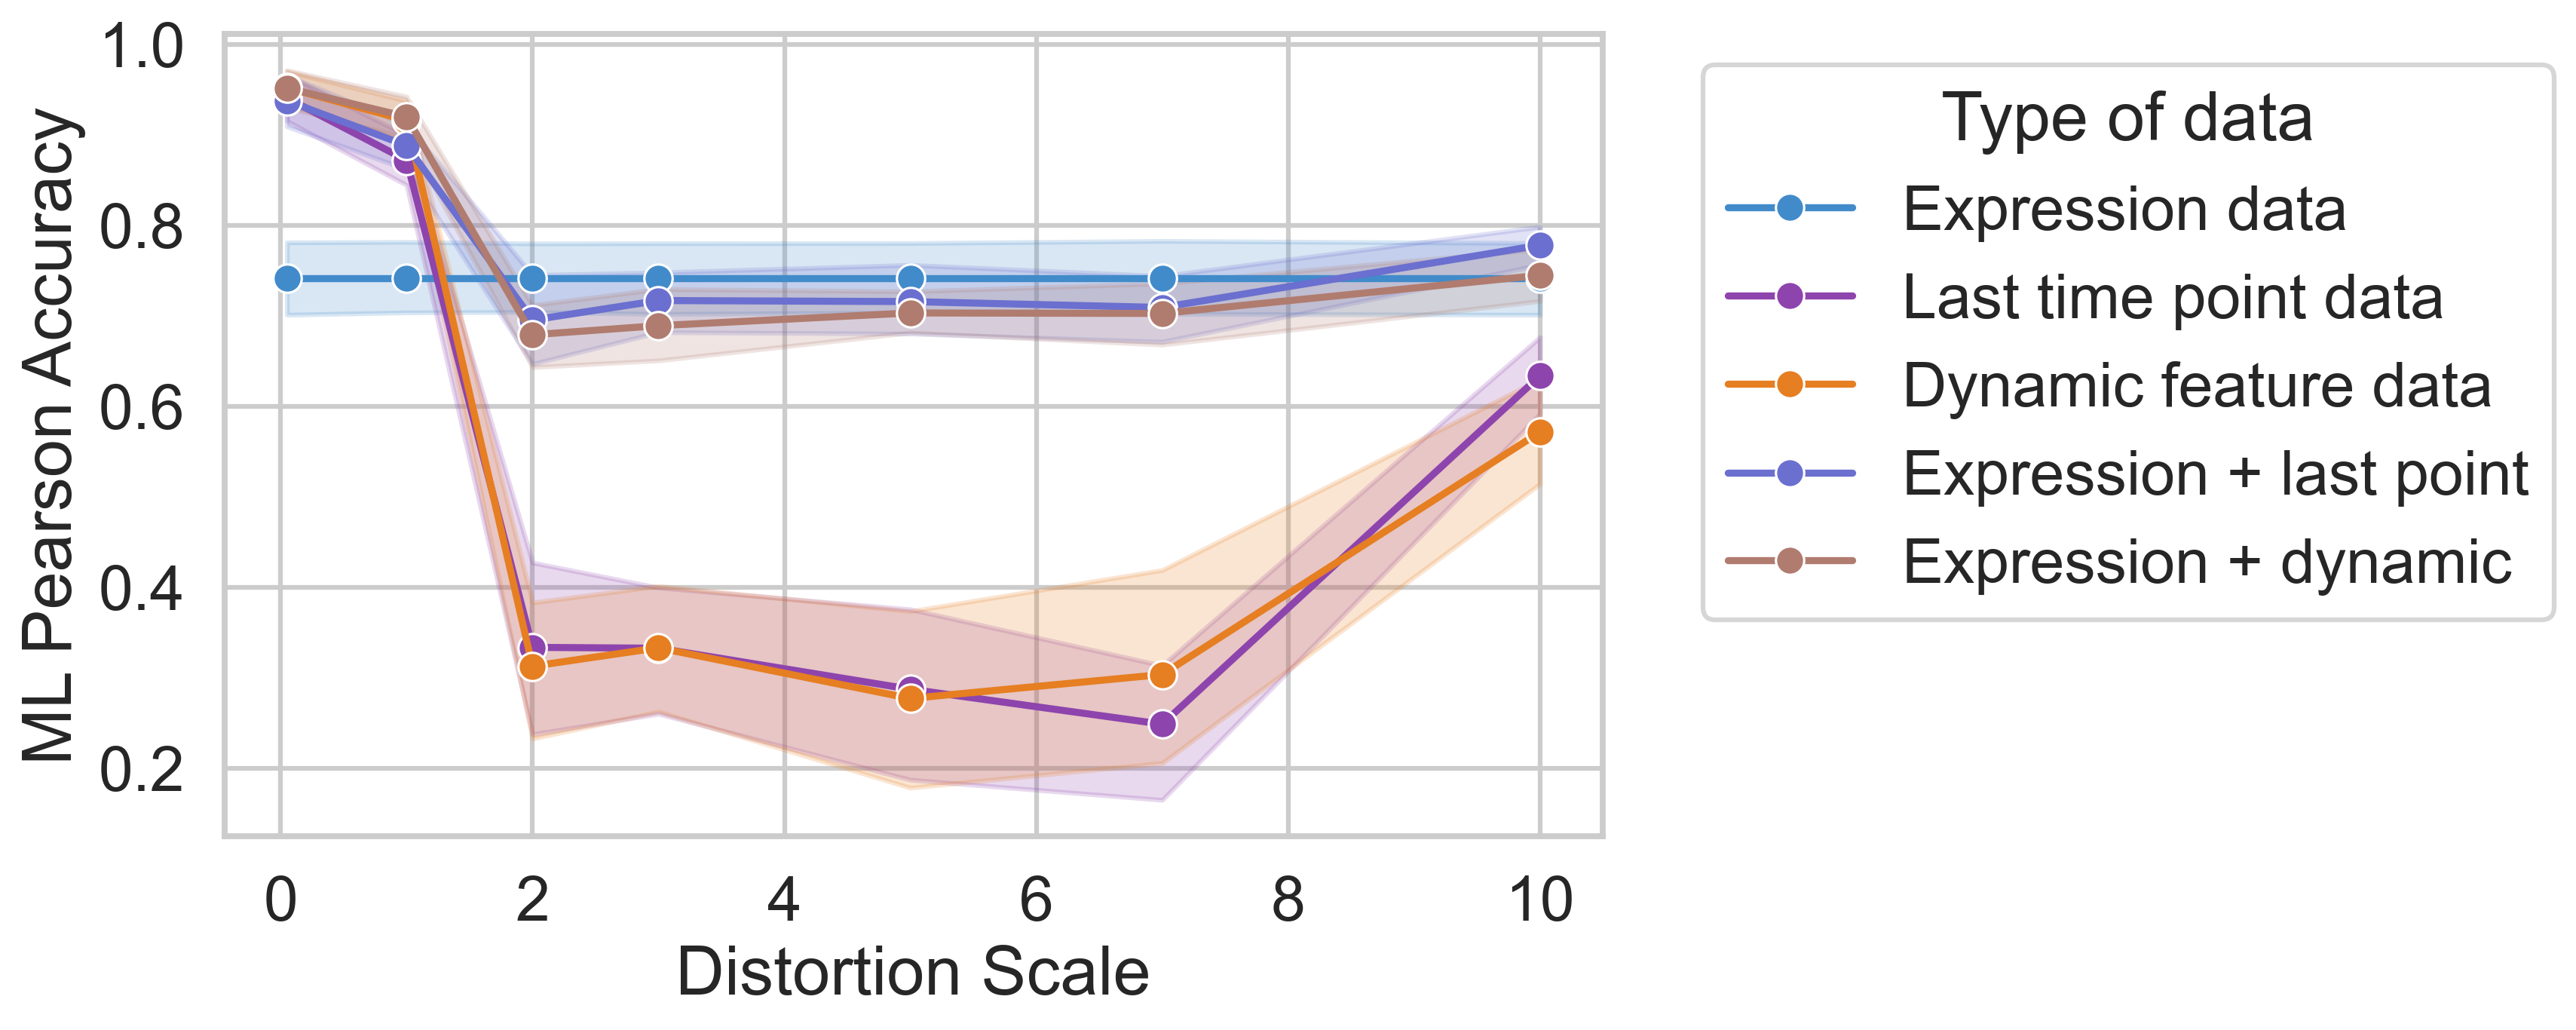

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocess data
plot_data = results_df.copy()
# filter out plot data where distortion_scale is above 5
# plot_data = plot_data[plot_data['distortion_scale'] <= 5]

plot_data = plot_data[plot_data['Model'] == 'Random Forest']


plot_data['Feature Data'] = plot_data['Feature Data'].replace({
    'feature_data': 'Expression data',
    'last_time_data': 'Last time point data',
    'dynamic_data': 'Dynamic feature data',
    'combined_lp_data': 'Expression + last point',
    'combined_dyn_data': 'Expression + dynamic',
    'combined expression + last time point': 'Expression + last point',
    'combined expression + dynamic feature': 'Expression + dynamic'
})


# Define the custom color palette
color_map = {
    'Expression data': '#428bca',
    'Last time point data': '#8e44ad',
    'Dynamic feature data': '#e67e22',
    'Expression + last point': '#6b6fcf',
    'Expression + dynamic': '#b07c6f'
}

# Set up plot appearance
plt.figure(figsize=(12, 5), dpi=300)
sns.set_style("whitegrid", {"font": "Arial"})
sns.set_context("talk", font_scale=1.2)

# Plot the line chart using the color map
sns.lineplot(
    data=plot_data,
    x='distortion_scale',
    y='Pearson Correlation',
    hue='Feature Data',
    palette=color_map,
    marker='o'
)

# Rotate x-axis labels
plt.xticks(rotation=0)

plt.ylabel('ML Pearson Accuracy')
plt.xlabel('Distortion Scale')


# Legend to the right
plt.legend(title='Type of data', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()